## 1 Fill NAN using regression models
##### In this I use different Models to fit the Missing (NAN) Values and generate a model to predict the class of defaulters or non-defaulters.\

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
import warnings
import pickle
import pandas as pd
import numpy as np
transformed_df = pickle.load(open("dataframe_with_nan.p","r"))

## 2 Make the Training and Testing Data with the Not NAN rows 

In [19]:
df_not_nan = transformed_df[pd.notnull(transformed_df['mths_since_last_major_derog'])]


In [20]:
df_not_nan = df_not_nan.drop('loan_status',axis = 1)
X_not_nan = np.array(df_not_nan.drop('mths_since_last_major_derog',axis = 1))
Y_not_nan = np.array(df_not_nan['mths_since_last_major_derog'])

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train_not_nan, X_test_not_nan, y_train_not_nan, y_test_not_nan = train_test_split(X_not_nan,Y_not_nan, test_size=0.2, random_state=1)

In [23]:
import pickle
pickle.dump(X_not_nan , open( "X_not_nan.p", "wb" ) )
pickle.dump(Y_not_nan , open( "Y_not_nan.p", "wb" ) )


## 3. Using Different models to fill the Missing Values

###### In this part I try out CART, Ridge Regression and Bayesian Ridge regression models and try to get the best fit possible by visualizing the predicted and actual Samples
###### Although the models didn perform exceptionally well , CART seemed to perform slightly better than the rest as there was some sense of linearity in the predicted and actual values.

### 3.1 CART 

In [24]:

from sklearn import tree
model1 = tree.DecisionTreeRegressor(max_depth=5)
model1 = model1.fit(X_train_not_nan, y_train_not_nan)
predicted = model1.predict(X_test_not_nan)


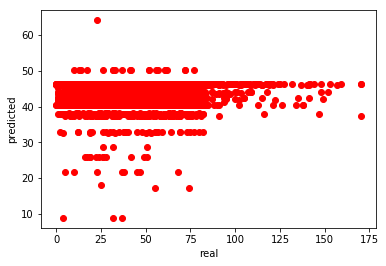

In [25]:
%matplotlib inline
import pylab as pl
pl.plot(y_test_not_nan,predicted,'ro')
#pl.plot([0,50],[0,50], 'g-')
pl.xlabel('real')
pl.ylabel('predicted')
pl.show()

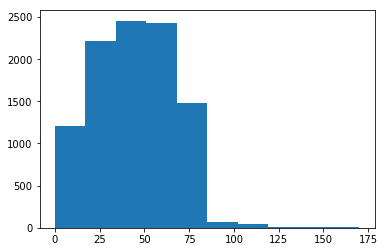

In [26]:
%matplotlib inline
import pylab as pl
pl.hist(y_test_not_nan)
#pl.plot([0,50],[0,50], 'g-')
#pl.xlabel('real')
#pl.ylabel('predicted')
pl.show()

### 3.2 Ridge Regression

In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

model2 = make_pipeline(PolynomialFeatures(2), Ridge())
model2.fit(X_train_not_nan, y_train_not_nan)
predicted = model2.predict(X_test_not_nan)


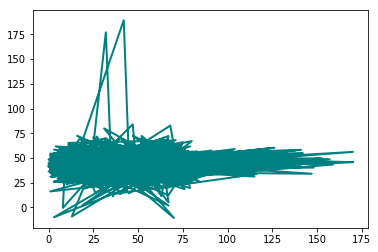

In [28]:
import matplotlib.pyplot as plt
colors = ['teal', 'yellowgreen', 'gold']
plt.plot(y_test_not_nan, predicted, color=colors[0], linewidth=2,
             label="degree %d" % 2)

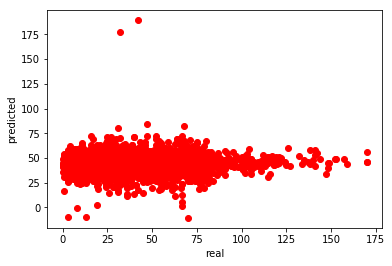

In [29]:
%matplotlib inline
import pylab as pl
pl.plot(y_test_not_nan,predicted,'ro')
#pl.plot([0,50],[0,50], 'g-')
pl.xlabel('real')
pl.ylabel('predicted')
pl.show()

### 3.3 Bayesian Ridge Regression

In [30]:
from sklearn.linear_model import BayesianRidge, LinearRegression
LinearRegression = BayesianRidge()
model3 = LinearRegression.fit(X_train_not_nan, y_train_not_nan)
model3.coef_
predicted = model3.predict(X_test_not_nan)


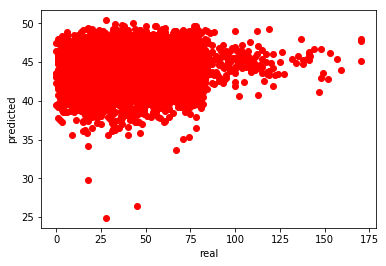

In [31]:
%matplotlib inline
import pylab as pl
pl.plot(y_test_not_nan,predicted,'ro')
#pl.plot([0,50],[0,50], 'g-')
pl.xlabel('real')
pl.ylabel('predicted')
pl.show()

## 4 Choosing CART for the final Prediction of NAN

In [32]:
df_is_nan = transformed_df[pd.isnull(transformed_df['mths_since_last_major_derog'])]
status = df_is_nan['loan_status']
df_is_nan = df_is_nan.drop('loan_status',axis = 1)
X_is_nan = np.array(df_is_nan.drop('mths_since_last_major_derog',axis = 1))
predicted = []
for i in xrange(len(X_is_nan)):
    predicted.append(int(model1.predict(X_is_nan[i])[0]))
    warnings.filterwarnings('ignore')
df_is_nan['mths_since_last_major_derog'] = predicted
df_is_nan['loan_status'] = status
df_not_nan = transformed_df[pd.notnull(transformed_df['mths_since_last_major_derog'])]


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [33]:
df_new = df_is_nan.append(df_not_nan)
df_new.shape

(199989, 98)

## 5 Undersampling for Prediction
##### In this I did a part of building the classification model using UnderSampling, where I take random samples from the majority group and make my data set with equal representation of defaulters and non-defaulters.

In [34]:
default_class = df_new[df_new['loan_status'] ==  1]
non_default_class = df_new[df_new['loan_status'] ==  0]
non_default_class = non_default_class.sample(n= default_class.shape[0]) 
undersampled_df = default_class.append(non_default_class, ignore_index=True)
undersampled_df = undersampled_df.sample(frac=1)
undersampled_df.shape[0]

(13342, 98)
(13342, 98)


26684

In [35]:
X = df_new.drop('loan_status', axis=1)
Y=  df_new['loan_status']

In [36]:
def F1_score(precision,recall):
    temp = []
    for i,j in zip(precision,recall):
        temp.append(2 * (i * j) / (i + j))
    return temp

In [37]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

### 5.1 Using Random Forest 

###### Using Random Forest of this gives pretty good accuracy but very bad precision and recall.

In [47]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,Y, test_size=0.3, random_state=1)

# Tried Parameter setting using different combinations and verifying against CV scores
max_score = 0
for i in xrange(10,50,10):
    for j in xrange(10, 25, 5):
        for k in xrange(10, 50, 10):
            #print "num of features,depth,estimators", i,j,k
            model2 = RandomForestClassifier(n_estimators=k,max_depth=j,max_features=i)
            features = model2.fit(X_train, y_train)
            predicted = model2.predict(X_test)
            # generate class probabilities
            probs = model2.predict_proba(X_test)
            #print probs     
            scores = cross_val_score(model2, X, Y, cv = 5)
            mean =  scores.mean()
            if mean > max_score : 
                accuracy =  sklearn.metrics.accuracy_score(y_test, predicted)
                roc_score = sklearn.metrics.roc_auc_score(y_test, predicted)
                confusion_matrix = sklearn.metrics.confusion_matrix(y_test, predicted)
                classification_report = sklearn.metrics.classification_report(y_test, predicted)
print sklearn.metrics.accuracy_score(y_test, predicted)
print sklearn.metrics.roc_auc_score(y_test, predicted)
print sklearn.metrics.confusion_matrix(y_test, predicted)
print sklearn.metrics.classification_report(y_test, predicted)


0.934230044836
0.500444788209
[[56047     7]
 [ 3939     4]]
             precision    recall  f1-score   support

          0       0.93      1.00      0.97     56054
          1       0.36      0.00      0.00      3943

avg / total       0.90      0.93      0.90     59997



In [ ]:
false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(y_test,probs[:,1])
roc_auc = sklearn.metrics.auc(false_positive_rate, true_positive_rate)

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 5.2 Using Logistic Regression

##### logistic performs slightly better than Random Forest. The AUC is around 0.75 with not so good precision and recall.

##### Note : I experimented these two models with replacing the NAN with mean.value as well and the performance doesn't vary much. 

In [40]:
import sklearn
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,Y, test_size=0.3, random_state=1)
value = 0.0

model2 = LogisticRegression(class_weight='balanced',penalty='l2')
features = model2.fit(X_train, y_train)
predicted = model2.predict(X_test)
# generate class probabilities
probs = model2.predict_proba(X_test)
#print probs
print sklearn.metrics.accuracy_score(y_test, predicted)
print sklearn.metrics.roc_auc_score(y_test, predicted)
print sklearn.metrics.confusion_matrix(y_test, predicted)
print sklearn.metrics.classification_report(y_test, predicted)
#scores = cross_val_score(model2, X, Y, cv = 5)
#print scores.mean()

0.712302281781
0.6796937984
[[40204 15850]
 [ 1411  2532]]
             precision    recall  f1-score   support

          0       0.97      0.72      0.82     56054
          1       0.14      0.64      0.23      3943

avg / total       0.91      0.71      0.78     59997



#### Here I tried manual  Thresholding by trying out different combinations to give a high cuttoff for it to be classified to class : 1. 
#### The other alternative method that I tried playing around was chaning the weights of each class when training the unsampled model, based on the percentage representation of each group by numbers. Example : For class: 1 I gave a weight factor of 1 and for class: 0 I gave a weight factor of 0.3. 

In [41]:
print probs
predicted = []
for i in xrange(len(probs)):
    if probs[i][1] > 0.55:
        predicted.append(1)
    else:
        predicted.append(0)
print sklearn.metrics.accuracy_score(y_test, predicted)
print sklearn.metrics.confusion_matrix(y_test, predicted)
print sklearn.metrics.classification_report(y_test, predicted)
        

[[ 0.56501939  0.43498061]
 [ 0.78993563  0.21006437]
 [ 0.48602972  0.51397028]
 ..., 
 [ 0.37165061  0.62834939]
 [ 0.80998541  0.19001459]
 [ 0.48327793  0.51672207]]
0.766638331917
[[43855 12199]
 [ 1802  2141]]
             precision    recall  f1-score   support

          0       0.96      0.78      0.86     56054
          1       0.15      0.54      0.23      3943

avg / total       0.91      0.77      0.82     59997



In [45]:
false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(y_test,probs[:,1])
roc_auc = sklearn.metrics.auc(false_positive_rate, true_positive_rate)

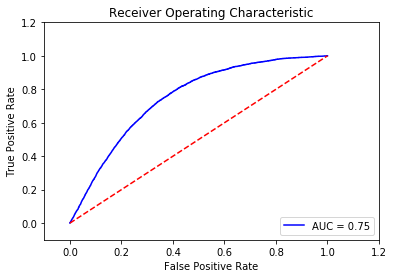

In [46]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()